In [1]:
# import jax
# import jax.numpy as jnp

# jax.config.update("jax_compilation_cache_dir", "./jax-caches")
# jax.config.update("jax_persistent_cache_min_entry_size_bytes", -1)
# jax.config.update("jax_persistent_cache_min_compile_time_secs", 0)

In [2]:
import sys
import os

sys.path.insert(0, os.path.abspath("."))
sys.path.insert(0, os.path.abspath("."))
sys.path.append(os.path.abspath("../"))

# os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "0.25"
# os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"
# os.environ["XLA_FLAGS"] = (
#     "--xla_disable_hlo_passes=constant_folding "  # this disables constant folding
#     # "--xla_cpu_use_thunk_runtime=false "
# )
from desc import set_device
set_device("gpu")

In [3]:
# import jax
# import jax.numpy as jnp

# jax.config.update("jax_explain_cache_misses", True)

In [4]:
# from desc import set_device, _set_cpu_count

# num_device = 2
# _set_cpu_count(num_device)
# set_device("cpu", num_device=num_device)

In [5]:
import numpy as np
np.set_printoptions(linewidth=np.inf, precision=4, suppress=True, threshold=sys.maxsize)
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.graph_objects as go
import functools
import scipy

In [6]:
import desc

from desc.basis import *
from desc.backend import *
from desc.compute import *
from desc.coils import *
from desc.equilibrium import *
from desc.examples import *
from desc.grid import *
from desc.geometry import *
from desc.io import *

from desc.objectives import *
from desc.objectives.objective_funs import *
from desc.objectives.getters import *
from desc.objectives.normalization import compute_scaling_factors
from desc.objectives.utils import *
from desc.optimize._constraint_wrappers import *

from desc.transform import Transform
from desc.plotting import *
from desc.optimize import *
from desc.perturbations import *
from desc.profiles import *
from desc.compat import *
from desc.utils import *
from desc.magnetic_fields import *
from desc.particles import *
from diffrax import *

from desc.__main__ import main
from desc.vmec_utils import vmec_boundary_subspace
from desc.input_reader import InputReader
from desc.continuation import solve_continuation_automatic
from desc.compute.data_index import register_compute_fun
from desc.optimize.utils import solve_triangular_regularized

print_backend_info()

DESC version=0.16.0+431.g27a83e1ba.
Using JAX backend: jax version=0.6.2, jaxlib version=0.6.2, dtype=float64.
Using device: NVIDIA GeForce RTX 4080 Laptop GPU (id=0), with 1.63 GB available memory.


In [7]:
sigma = np.logspace(-8, 4, 100)
sigma_min = sigma[0]
alphas = np.logspace(-6, 1, 15)

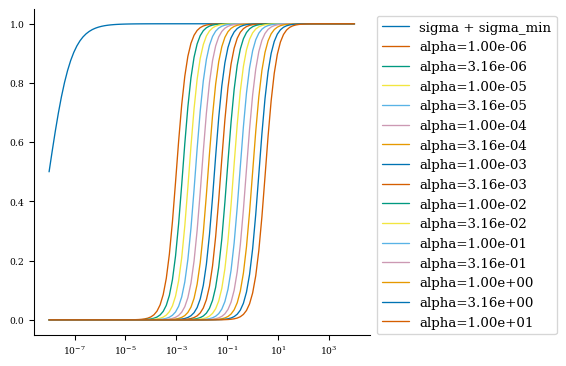

In [8]:
plt.semilogx(sigma, sigma/(sigma+sigma_min), label="sigma + sigma_min")
for alpha in alphas:
    plt.semilogx(sigma, sigma**2 / (sigma**2 + alpha), label=f"alpha={alpha:.2e}")
plt.legend(bbox_to_anchor=(1.001, 1), loc='upper left')
plt.tight_layout()

In [9]:
class FixLambdaGaugeNew(FixParameters):
    _units = "(rad)"
    _print_value_fmt = "lambda gauge error: "

    def __init__(
        self,
        eq,
        normalize=True,
        normalize_target=True,
        name="lambda gauge",
    ):
        indices = np.where(
            np.logical_and(eq.L_basis.modes[:, 1] == 0, eq.L_basis.modes[:, 2] != 0)
        )[0]
        super().__init__(
            thing=eq,
            params={"L_lmn": indices},
            target=0,
            normalize=normalize,
            normalize_target=normalize_target,
            name=name,
        )

In [41]:
eq = get("precise_QA")
eq = Equilibrium(M=8, N=8)
cons = get_fixed_boundary_constraints(eq)
# cons += (FixLambdaGaugeNew(eq),)
cons = maybe_add_self_consistency(eq, cons)
con = ObjectiveFunction(cons)
obj = ObjectiveFunction(ForceBalance(eq))
lcp = LinearConstraintProjection(obj, con)
lcp.build()

Building objective: force
Precomputing transforms
Building objective: fixed LCFS R
Building objective: fixed LCFS Z
Building objective: fixed Psi
Building objective: fixed pressure
Building objective: fixed current
Building objective: fixed sheet current
Building objective: self_consistency lcfs R
Building objective: self_consistency lcfs Z
Building objective: lambda gauge
Building objective: self_consistency axis R
Building objective: self_consistency axis Z


In [42]:
J = obj.jvp_scaled_error(lcp._feasible_tangents.T, obj.x(eq), obj.constants).T

In [43]:
uf, sf, vtf = jnp.linalg.svd(J, full_matrices=True)
print(f"{sf[0]/sf[-1]:.3e}")

3.275e+15


In [44]:
J.shape, uf.shape, sf.shape, vtf.shape, lcp._Z.shape

((10098, 1712), (10098, 10098), (1712,), (1712, 1712), (2188, 1712))

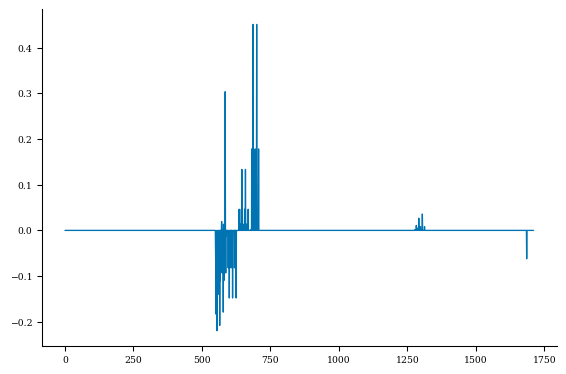

In [68]:
plt.plot(vtf[0, :])

Text(0.5, 1.0, 'Eigenvector in smallest singular value')

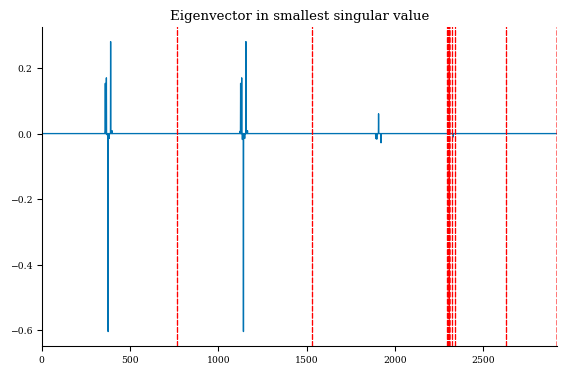

In [46]:
smallest_v_dir = put(jnp.zeros(eq.dim_x), lcp._unfixed_idx, lcp._Z @ vtf[-1, :])
biggest_v_dir = put(jnp.zeros(eq.dim_x), lcp._unfixed_idx, lcp._Z @ vtf[0, :])
plt.plot(smallest_v_dir)
size_total = 0
# Add vertical lines to divide up the horizontal axis into parameters
for key, value in eq.params_dict.items():
    size = value.size
    size_total += size
    plt.axvline(x=size_total, color="r", linestyle="--")
plt.xlim([0, len(biggest_v_dir)])
plt.title("Eigenvector in smallest singular value")

Text(0.5, 1.0, 'Eigenvector in biggest singular value')

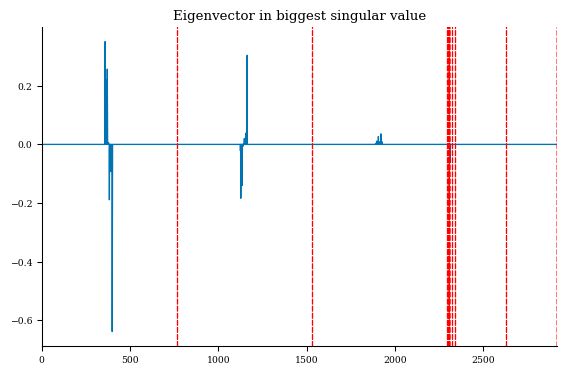

In [52]:
plt.plot(biggest_v_dir)
size_total = 0
# Add vertical lines to divide up the horizontal axis into parameters
for key, value in eq.params_dict.items():
    size = value.size
    size_total += size
    plt.axvline(x=size_total, color="r", linestyle="--")
plt.xlim([0, len(biggest_v_dir)])
plt.title("Eigenvector in biggest singular value")

In [47]:
jnp.linalg.norm(smallest_v_dir), jnp.linalg.norm(biggest_v_dir)

(Array(1., dtype=float64), Array(1., dtype=float64))

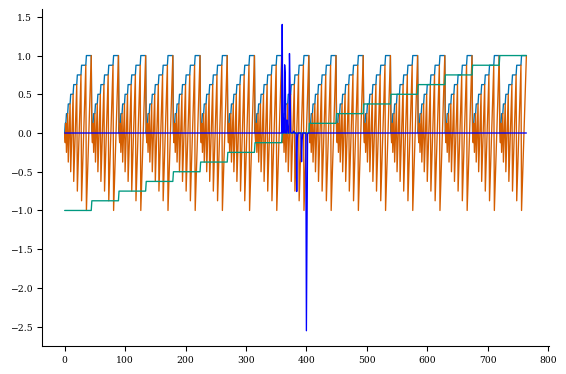

In [107]:
params = obj.unpack_state(smallest_v_dir)[0][0]
params2 = obj.unpack_state(biggest_v_dir)[0][0]
plt.plot(eq.R_basis.modes[:, 0]/eq.L)
plt.plot(eq.R_basis.modes[:, 1]/eq.M)
plt.plot(eq.R_basis.modes[:, 2]/eq.N)
# plt.plot(params["R_lmn"]*4, "k")
plt.plot(params2["R_lmn"]*4, "b")
# plt.savefig("smallest_eigv_R_comps.png", dpi=500)

In [49]:
idx = jnp.argmax(params["L_lmn"])
idxa = jnp.argmax(jnp.abs(params["L_lmn"]))
eq.L_basis.modes[idx, :], eq.L_basis.modes[idxa, :]

(array([ 7, -1,  0]), array([ 7, -1,  0]))

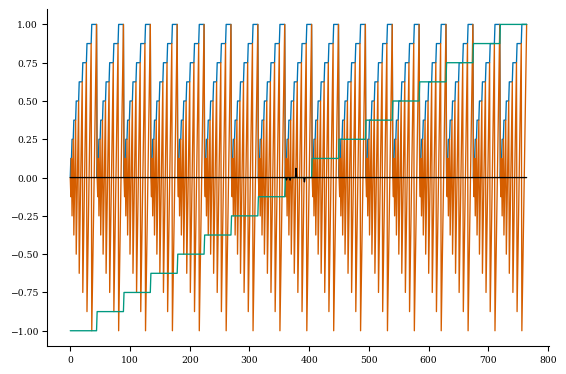

In [50]:
params = obj.unpack_state(smallest_v_dir)[0][0]
plt.plot(eq.L_basis.modes[:, 0] / eq.L)
plt.plot(eq.L_basis.modes[:, 1] / eq.M)
plt.plot(eq.L_basis.modes[:, 2] / eq.N)
plt.plot(params["L_lmn"], "k")
# plt.savefig("smallest_eigv_L_comps.png", dpi=500)

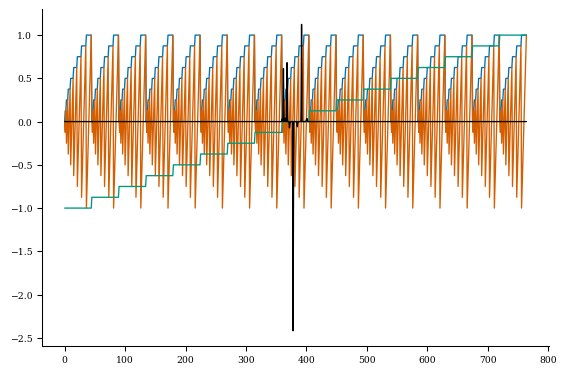

In [57]:
params = obj.unpack_state(smallest_v_dir)[0][0]
plt.plot(eq.Z_basis.modes[:, 0] / eq.L)
plt.plot(eq.Z_basis.modes[:, 1] / eq.M)
plt.plot(eq.Z_basis.modes[:, 2] / eq.N)
plt.plot(params["Z_lmn"]*4, "k")

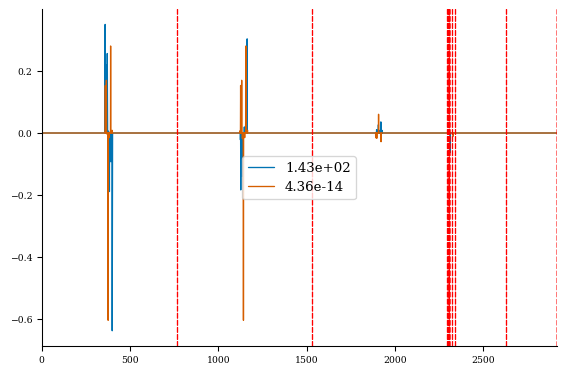

In [105]:
id = -1
plt.plot(put(jnp.zeros(eq.dim_x), lcp._unfixed_idx, lcp._Z @ vtf[0, :]), label=f'{sf[0]:.2e}')
plt.plot(
    put(jnp.zeros(eq.dim_x), lcp._unfixed_idx, lcp._Z @ vtf[id, :]),
    label=f"{sf[id]:.2e}",
)
# plt.plot(put(jnp.zeros(eq.dim_x), lcp._unfixed_idx, lcp._Z @ vtf[800, :]))
size_total = 0
# Add vertical lines to divide up the horizontal axis into parameters
for key, value in eq.params_dict.items():
    size = value.size
    size_total += size
    plt.axvline(x=size_total, color="r", linestyle="--")
plt.xlim([0, eq.dim_x])
plt.legend();

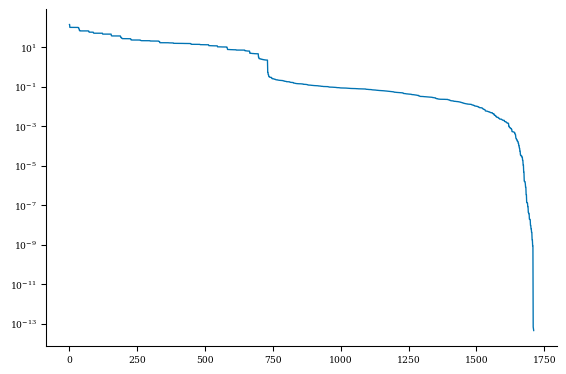

In [80]:
plt.semilogy(sf)

Original problem,

$$Ax = b$$

where $A \in \mathbb{R}^{N\times M}$. And the SVD of $A$ is,

$$A=U \Sigma V^T = \sum_i \sigma_i u_i v_i^T$$

The solution $x$ is,

$$x=V \Sigma^{-1} U^T b = \sum_i \frac{u_i^T b}{\sigma_i} v_i$$

For the `ProximalProjection`, we instead solve,

$$\tilde{A}x = U (\Sigma + \sigma_{min} \mathbb{I}_{aug}) V^T x = b$$

where $\mathbb{I}_{aug}$ is identity augmented with 0 rows. Then the solution is,

$$\tilde{x}= \sum_i \frac{u_i^T b}{\sigma_i + \sigma_{min}} v_i$$

For the ridgre regression (which is used in trust region subproblem), the solution becomes,

$$\tilde{x}= \sum_i \frac{\sigma_i}{\sigma_i^2 + \alpha} u_i^T b v_i$$

If we look at the component of $x$ in the orthogonal basis formed by $v$'s, the damping of the coefficients can be given as,

$$\frac{\tilde{x}_i}{x_i} = \frac{\sigma_i}{\sigma_i + \sigma_{min}}$$

$$\frac{\tilde{x}_i}{x_i} = \frac{\sigma_i^2}{\sigma_i^2 + \alpha}$$

for the `ProximalProjection` and ridge regression, respectively.

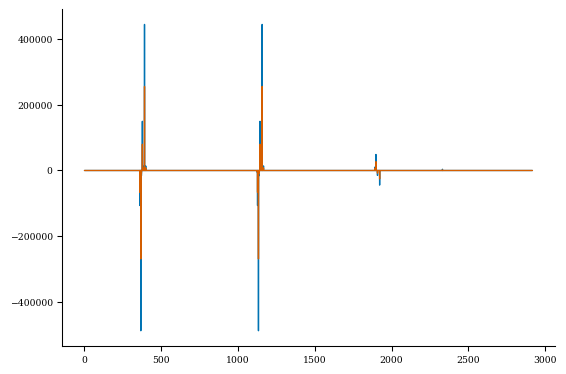

In [103]:
J = obj.jvp_scaled_error(lcp._feasible_tangents.T, obj.x(eq), obj.constants).T
uf, sf, vtf = jnp.linalg.svd(J, full_matrices=False)
f = obj.compute_scaled_error(obj.x(eq))
dx = -vtf.T @ (1 / sf * (uf.T @ f))
dx_reg = -vtf.T @ (1 / (sf+sf[-1]) * (uf.T @ f))
plt.plot(put(jnp.zeros(eq.dim_x), lcp._unfixed_idx, lcp._Z @ dx))
plt.plot(put(jnp.zeros(eq.dim_x), lcp._unfixed_idx, lcp._Z @ dx_reg))

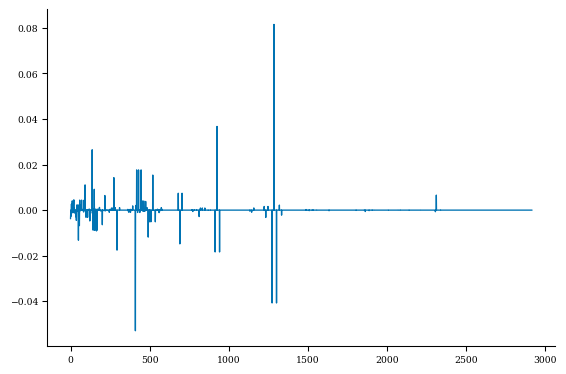

In [104]:
plt.plot(put(jnp.zeros(eq.dim_x), lcp._unfixed_idx, lcp._Z @ (uf.T @ f)))